# Problem Statement

When individuals relocate to a new city, selecting a suitable residential neighborhood becomes a complex decision due to the involvement of multiple factors such as rental affordability, air quality, commute distance, and availability of basic amenities.

Most existing platforms present this information separately, requiring users to manually compare data across different sources, which often leads to confusion and inefficient decision-making.

There is a need for a unified system that can analyze these factors together and provide a clear, comparative evaluation of neighborhoods to support informed relocation choices.

UrbanNest aims to address this problem by developing a data-driven neighborhood livability analysis system that combines key urban indicators into a single livability score, enabling users to easily compare and identify areas that best match their preferences.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
df=pd.read_csv("/content/Pune_Rent_Cleaned.csv")
df

,locality,avg_rent_1bhk,avg_rent_2bhk,avg_rent_3bhk,min_rent,max_rent
0,Akurdi,13000,20500,29000,13000,29000
1,Alandi,9500,15000,21000,9500,21000
2,Alandi Road,11000,17000,24000,11000,24000
3,Ambegaon Bk,9500,16000,23000,9500,23000
4,Ambegaon Budruk,11500,18500,26000,11500,26000
...,...,...,...,...,...,...
94,Wakad,19000,29500,44000,19000,44000
95,Wanwadi,16500,26000,38000,16500,38000
96,Warje,15000,23000,33000,15000,33000
97,Yerwada,16500,26000,38000,16500,38000


In [39]:
import pandas as pd

# Load dataset

def calculate_affordability(bhk_type):
    bhk_map = {
        "1bhk": "avg_rent_1bhk",
        "2bhk": "avg_rent_2bhk",
        "3bhk": "avg_rent_3bhk"
    }

    rent_col = bhk_map[bhk_type]

    min_rent = df[rent_col].min()
    max_rent = df[rent_col].max()

    df_result = df.copy()

    df_result["affordability_score"] = (
        100 * (max_rent - df_result[rent_col]) /
        (max_rent - min_rent)
    ).round(2)

    return df_result.sort_values("affordability_score", ascending=False)


# -----------------------------
# Example usage
# -----------------------------
selected_bhk = "1bhk"   # change to 1bhk / 2bhk / 3bhk

result = calculate_affordability(selected_bhk)

print(result[["locality", f"avg_rent_{selected_bhk}", "affordability_score"]].head(10))


            locality  avg_rent_1bhk  affordability_score
75            Saswad           8000               100.00
88     Uruli Kanchan           8500                97.92
17            Chakan           8500                97.92
83  Talegaon Dabhade           9000                95.83
48      Loni Kalbhor           9000                95.83
24              Dehu           9000                95.83
68          Pirangut           9500                93.75
3        Ambegaon Bk           9500                93.75
1             Alandi           9500                93.75
63         Phursungi           9500                93.75


In [40]:
import pandas as pd

aqi_df = pd.read_csv("/content/AQI_updated_with_score.csv")
aqi_df.head()


,Locality,AQI Number,AQI Status,AQI_Score
0,Akurdi,145,Poor,0.6
1,Alandi,130,Poor,0.6
2,Alandi Road,138,Poor,0.6
3,Ambegaon Bk,115,Moderate,0.6
4,Ambegaon Budruk,115,Moderate,0.6


In [41]:
def clean(text):
    return text.strip().lower()

aqi_df["Locality_clean"] = aqi_df["Locality"].apply(clean)
df["Locality_clean"] = df["locality"].apply(clean)


In [42]:
merged_df = df.merge(
    aqi_df[["Locality_clean", "AQI_Score"]],
    on="Locality_clean",
    how="left"
)

In [43]:
merged_df.isna().sum()


,0
locality,0
avg_rent_1bhk,0
avg_rent_2bhk,0
avg_rent_3bhk,0
min_rent,0
max_rent,0
Locality_clean,0
AQI_Score,0


In [44]:
merged_df["AQI_Score"].unique()


array([0.6, 0.8, 0.4])

In [45]:
merged_df[["locality", "AQI_Score"]].head(10)


,locality,AQI_Score
0,Akurdi,0.6
1,Alandi,0.6
2,Alandi Road,0.6
3,Ambegaon Bk,0.6
4,Ambegaon Budruk,0.6
5,Aundh,0.6
6,Balewadi,0.6
7,Baner,0.6
8,Bavdhan,0.6
9,Bhosari,0.6


In [46]:
merged_df["AQI_Score"].describe()


,AQI_Score
count,99.000000
mean,0.600000
std,0.040406
min,0.400000
25%,0.600000
50%,0.600000
75%,0.600000
max,0.800000


In [47]:
if 'Locality_clean' not in result.columns:
    result['Locality_clean'] = result['locality'].apply(clean)

merged_df = merged_df.merge(
    result[['Locality_clean', 'affordability_score']],
    on='Locality_clean',
    how='left'
)

merged_df["Livability_Score"] = (
    0.6 * merged_df["affordability_score"] +
    0.4 * merged_df["AQI_Score"]
)


In [48]:
livability_ranking = (
    merged_df.groupby("locality")["Livability_Score"]
    .mean()
    .sort_values(ascending=False)
)

livability_ranking.head(10)


,Livability_Score
locality,
Saswad,60.240
Uruli Kanchan,58.992
Chakan,58.912
Talegaon Dabhade,57.738
Loni Kalbhor,57.738
Dehu,57.738
Pirangut,56.490
Ambegaon Bk,56.490
Alandi,56.490


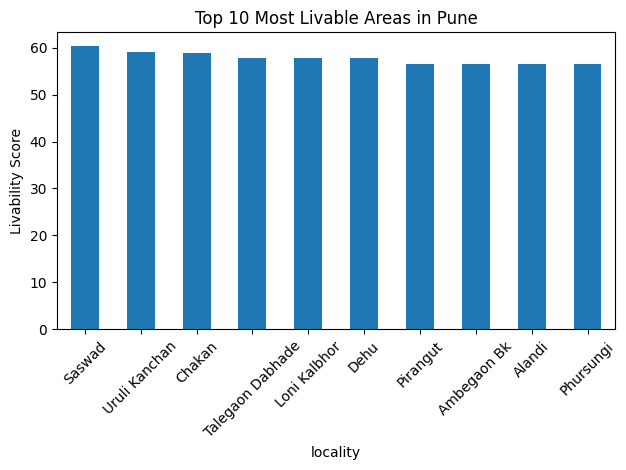

In [49]:
import matplotlib.pyplot as plt

livability_ranking.head(10).plot(kind="bar")
plt.title("Top 10 Most Livable Areas in Pune")
plt.ylabel("Livability Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
